# Inspect the LAS file tile index
The LAS file tile index is a geospatial file where each LAS file's spatial extent is represented as a polygonal feature within the vector layer. Attributes associated with a feature include, at a minimum, the path to the LAS file. Using the tile index it is easy to find all LAS files that fall within a spatial extent or county boundary or watershed boundary. 



In [77]:
from osgeo import ogr

database = 'lidar/tiles2.gpkg'
tindex = ogr.Open(database)
layer = tindex.GetLayer()
print('Database contains {} LAS files'.format(layer.GetFeatureCount()))

Database contains 18639 LAS files


In [146]:
%matplotlib inline
import geopandas as gpd

database = 'lidar/mclean/tiles.gpkg'
tindex = gpd.read_file(database)
tindex.info()
print(tindex.total_bounds)
tindex.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 5 columns):
location    8807 non-null object
srs         8807 non-null object
modified    8807 non-null object
created     8807 non-null object
geometry    8807 non-null object
dtypes: object(5)
memory usage: 344.1+ KB
[-89.27773406  40.27186748 -88.44891226  40.76310597]


,location,srs,modified,created,geometry
0,/data/lidar/mclean/LAS/864_1370.las,EPSG:3443,2014-03-10T19:50:18,2018-12-13T21:34:22,POLYGON ((-88.76526451751522 40.42767159762371...
1,/data/lidar/mclean/LAS/806_1432.las,EPSG:3443,2014-03-10T19:17:01,2018-12-13T21:34:22,"POLYGON ((-88.97520752537943 40.5968799745779,..."
2,/data/lidar/mclean/LAS/894_1426.las,EPSG:3443,2014-03-10T18:33:07,2018-12-13T21:34:22,POLYGON ((-88.65824901589571 40.58173719422296...
3,/data/lidar/mclean/LAS/784_1330.las,EPSG:3443,2014-03-10T17:14:35,2018-12-13T21:34:22,"POLYGON ((-89.051436432771 40.31645019268065, ..."
4,/data/lidar/mclean/LAS/878_1462.las,EPSG:3443,2014-03-10T17:13:22,2018-12-13T21:34:22,POLYGON ((-88.71641494811547 40.68037368354577...


In [138]:
import pandas as pd
tindex['srs'].unique()

array(['EPSG:3443'], dtype=object)

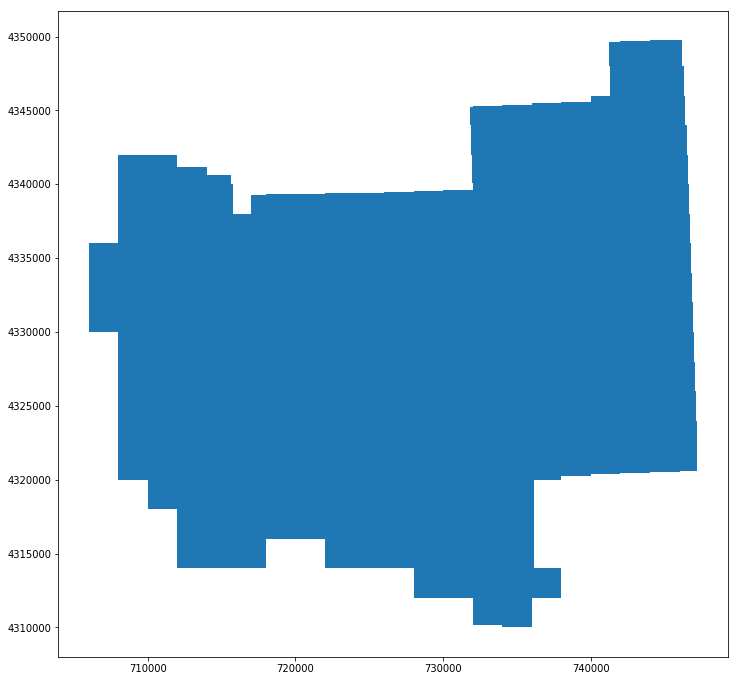

In [144]:
tindex.iloc[0]['geometry'].bounds
tindex.plot(figsize=(12.0, 12.0))


The following functions were lifted from [StackExchange](https://gis.stackexchange.com/questions/90553/fiona-get-each-feature-extent-bounds) and recursively decend into the coordinates to determine the extents of each feature (ie LAS file).

In [19]:
def explode(coords):
    for e in coords:
        if isinstance(e, (float, int)):
            yield coords
            break
        else:
            for f in explode(e):
                yield f
                
def bbox(f):
    x, y = zip(*list(explode(f['geometry']['coordinates'])))
    return min(x), min(y), max(x), max(y)


In [55]:
import fiona
import pyproj

with fiona.open(dbase) as fc:
    for feature in fc.values(3):
        print(feature['properties']['location'])
        minx, miny, maxx, maxy = bbox(feature)
        print(f'{minx},{miny}; {maxx},{maxy}\n')
        
        print('projection = {}'.format(feature['properties']['srs']))
        proj = pyproj.Proj("+init={}".format(feature['properties']['srs']), preserve_units=True)
        
        pminx, pminy = proj(minx, miny)
        print(f'{pminx}, {pminy}')

/data/lidar/mclean/LAS/864_1370.las
-88.76529964177888,40.427671597623714; -88.75808085561759,40.43318795162409

projection = EPSG:3443
863990.2213460101, 1370000.0478077969
/data/lidar/mclean/LAS/806_1432.las
-88.97526003397633,40.5968799745779; -88.9680060292617,40.60240916095911

projection = EPSG:3443
805985.4181421811, 1432000.1063111892
/data/lidar/mclean/LAS/894_1426.las
-88.65827558188253,40.58173719422296; -88.65104881075173,40.587246880534465

projection = EPSG:3443
893992.6209030794, 1426000.0272234173


In [57]:
with fiona.open(dbase) as fc:
    #print(len(list(fc.items(bbox=(-88.7655,41.0,-88.750,40.75)))))
    for f in fc.values(bbox=(-88.7555,41.0,-88.750,40.75)):
        print(f['properties']['location'])

/data/lidar/mclean/LAS/866_1490.las
/data/lidar/mclean/LAS/866_1488.las
/data/lidar/mclean/LAS/866_1486.las
/data/lidar/mclean/LAS/868_1490.las
/data/lidar/mclean/LAS/868_1486.las
/data/lidar/mclean/LAS/868_1488.las
